In [ ]:
from pathlib import Path

In [25]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process

def make_choropleths(df, country_col, col1, col2, shapefile_path):
    # Load shapefile
    world = gpd.read_file(shapefile_path)
    shapefile_countries = world['ADMIN'].unique()

    # Match country names
    def match_country(name):
        match = process.extractOne(name, shapefile_countries, scorer=fuzz.partial_ratio)
        if match and match[1] > 80:
            return match[0]
        return None

    df = df.copy()
    df['Mapped Country'] = df[country_col].apply(match_country)

    # Merge
    merged = world.merge(df, how="left", left_on="ADMIN", right_on="Mapped Country")

    # Plotting
    sns.set_theme(style="whitegrid")
    plt.rcParams['font.family'] = 'Georgia'
    plt.rcParams['axes.facecolor'] = '#f5f5f5'

    fig, ax = plt.subplots(1, 2, figsize=(20, 12))

    for i, column in enumerate([col1, col2]):
        merged.boundary.plot(ax=ax[i], linewidth=0.8, color='black')
        merged.plot(
            column=column,
            ax=ax[i],
            legend=True,
            legend_kwds={'label': column, 'orientation': "horizontal"},
            cmap='YlOrRd' if i else 'YlGnBu',
            missing_kwds={"color": "lightgrey", "label": "No data"}
        )
        ax[i].set_title(f"{column} by Country", fontsize=18, fontweight='bold')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
shapefile_path = "data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"


In [15]:
merged_path = Path('data') / 'final_merged_df.csv'
merged_df = pd.read_csv(merged_path)
merged_df.head()

,Name,Average Sleep Quality (0-1),Average Sleep Duration (Hours),SES,gdppc,Air Pollution (PM 2.5)
0,Canada,0.770628,7.56,93.772118,40699.3550,6.04
1,Colombia,0.729727,7.12,59.636009,10900.5040,16.23
2,India,0.706097,6.97,22.542639,4404.5376,41.39
3,Israel,0.740612,7.23,86.517677,29599.7930,14.32
4,Sweden,0.786576,7.69,91.959633,42942.5630,4.86


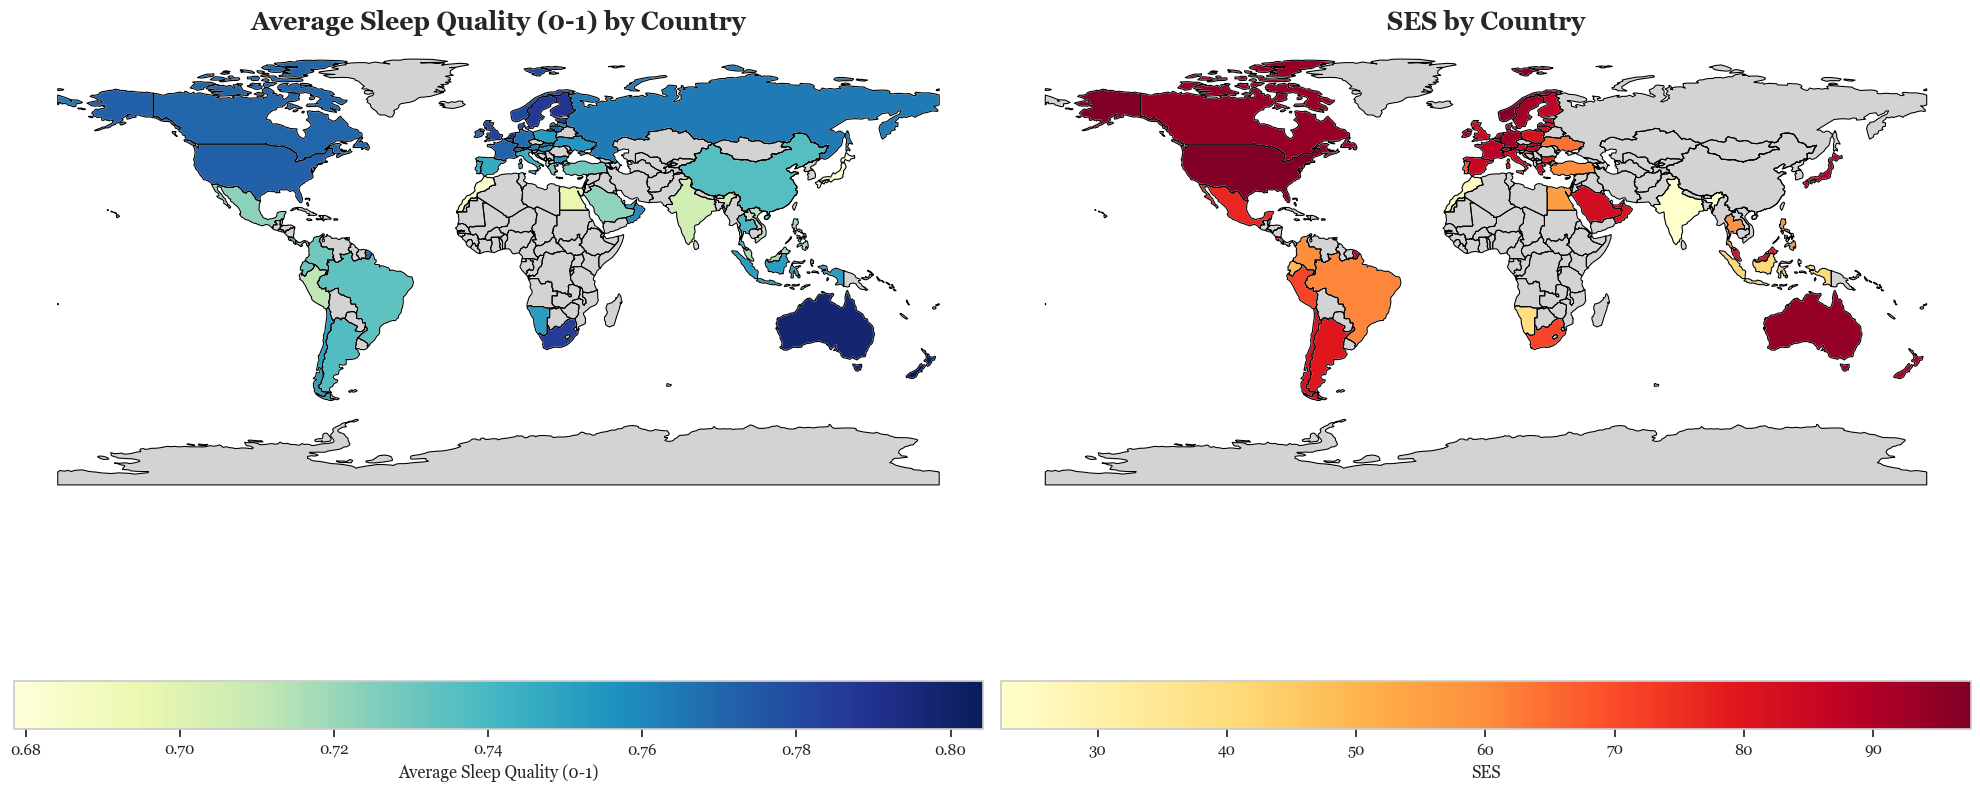

In [27]:
make_choropleths(merged_df, 'Name', 'Average Sleep Quality (0-1)', 'SES', shapefile_path)

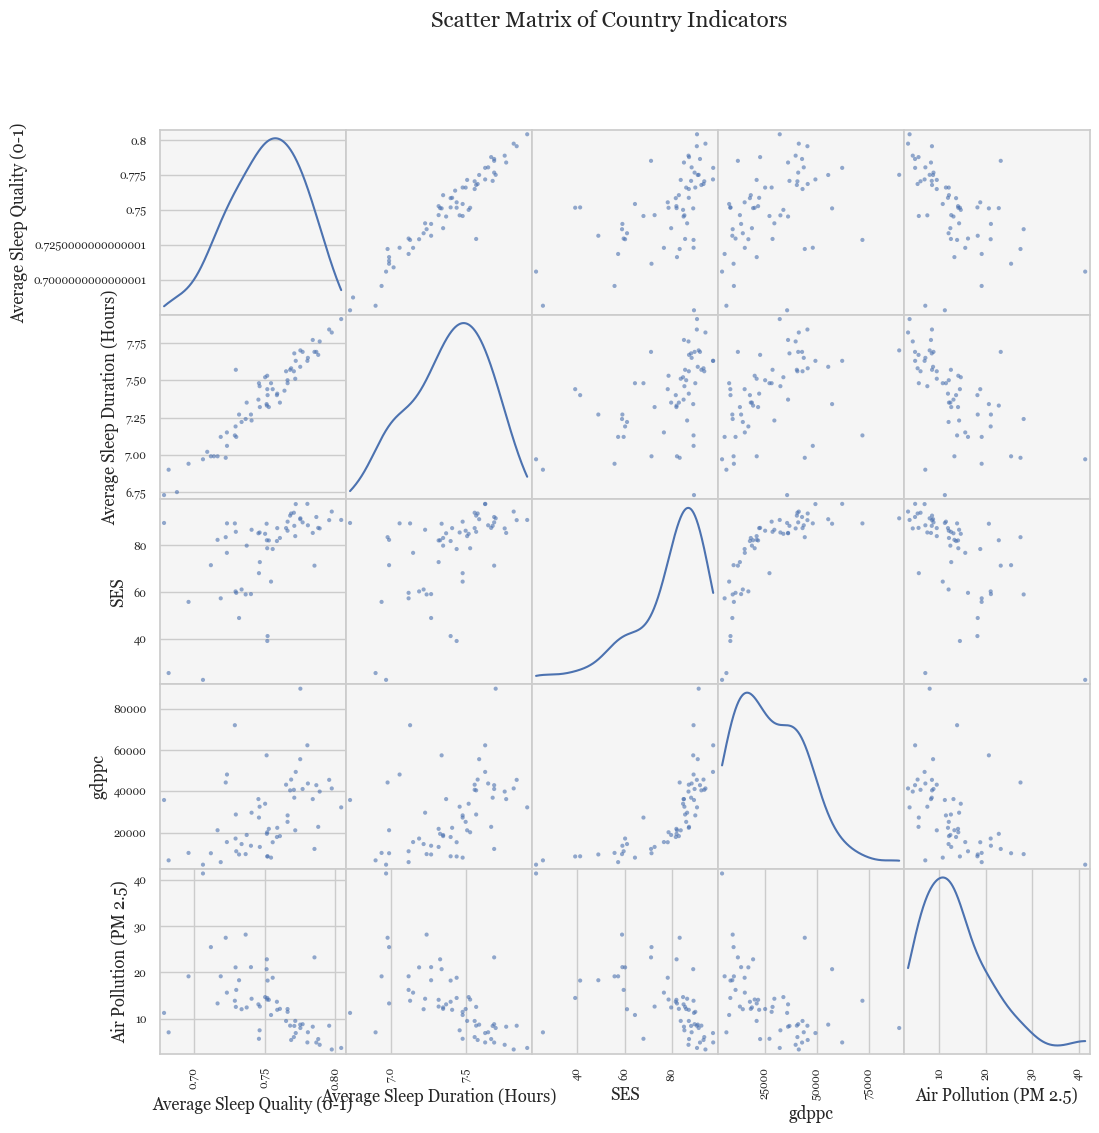

In [23]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Select only numeric columns (drop Country)
numeric_cols = merged_df.select_dtypes(include='number')

scatter_matrix(numeric_cols, figsize=(12, 12), diagonal='kde', alpha=0.6)
plt.suptitle("Scatter Matrix of Country Indicators", fontsize=16)
plt.show()

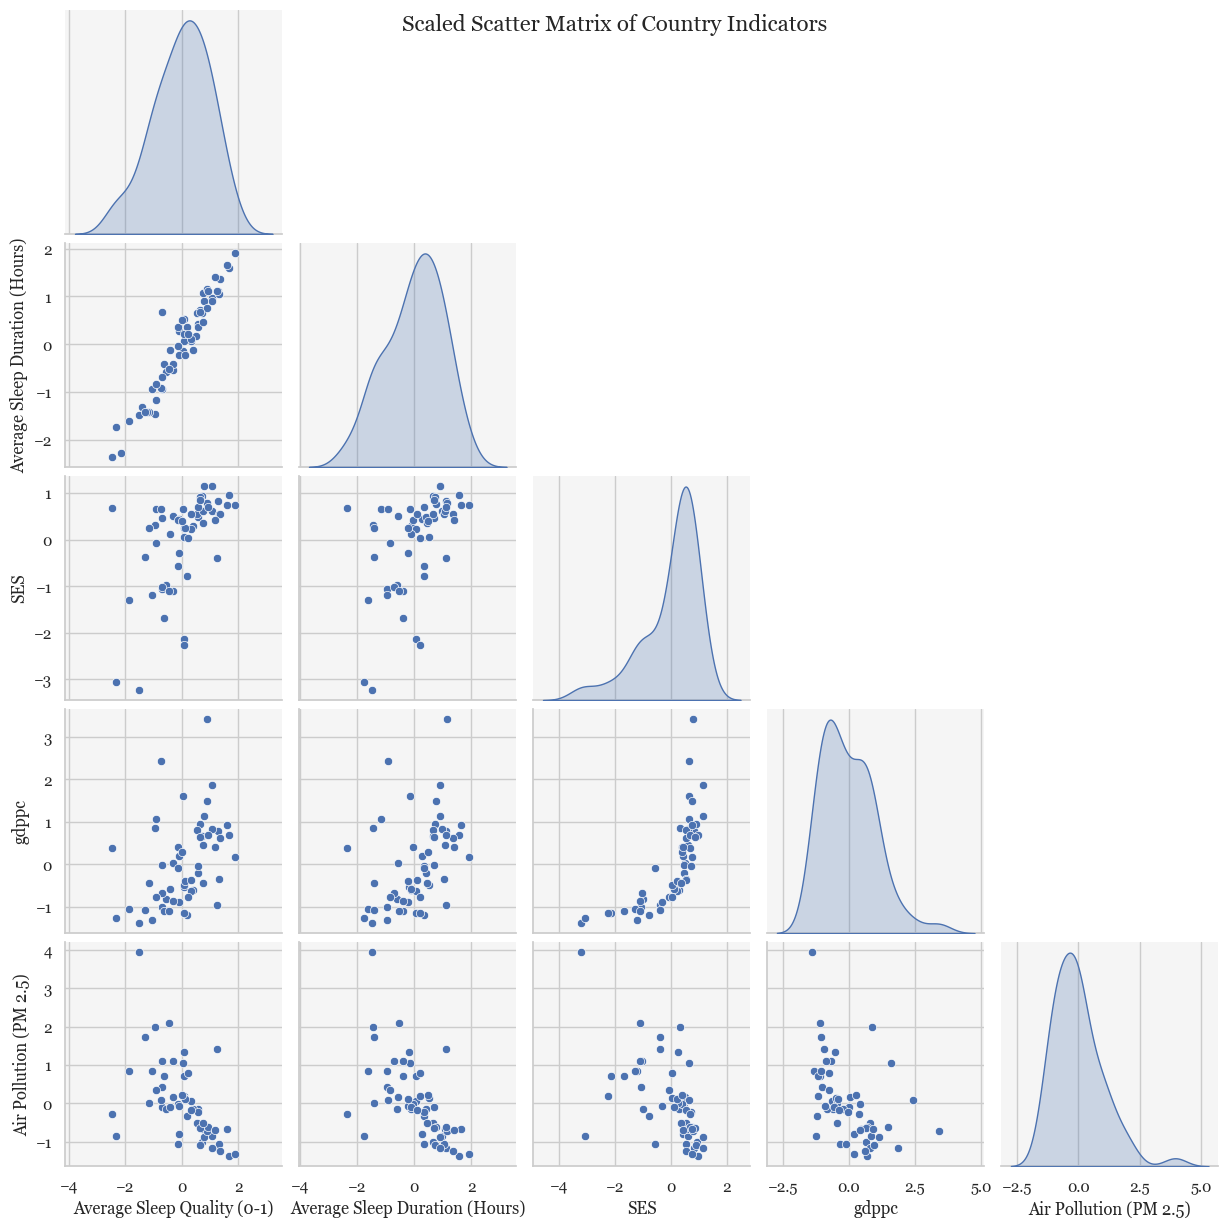

In [28]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['Average Sleep Quality (0-1)', 'Average Sleep Duration (Hours)',
                'SES', 'gdppc', 'Air Pollution (PM 2.5)']

scaled = StandardScaler().fit_transform(merged_df[numeric_cols])
scaled_df = pd.DataFrame(scaled, columns=numeric_cols)

sns.pairplot(scaled_df, diag_kind='kde', corner=True)
plt.suptitle("Scaled Scatter Matrix of Country Indicators", fontsize=16)
plt.show()